# Fake News Detection using Machine Learning & NLP
This notebook demonstrates a complete end-to-end workflow for detecting fake news using text classification.

##  1. Import Libraries

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import string
import re
import joblib
import os

##  2. Load & Preprocess Dataset

In [46]:
df_fake = pd.read_csv('../data/Fake.csv')
df_real = pd.read_csv('../data/True.csv')

df_fake['label'] = 0
df_real['label'] = 1
df = pd.concat([df_fake, df_real], ignore_index=True).sample(frac=1, random_state=42).reset_index(drop=True)

df['content'] = df['title'] + " " + df['text']

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\[.*?\]', '', text)
    text = re.sub(r'https?://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>+', '', text)
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub(r'\n', '', text)
    text = re.sub(r'\w*\d\w*', '', text)
    return text

df['content'] = df['content'].apply(clean_text)

X = df['content']
y = df['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 3. TF-IDF Vectorization

In [47]:
vectorizer = TfidfVectorizer(stop_words='english', max_df=0.7)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

joblib.dump(vectorizer, '../models/tfidf_vectorizer.pkl')

['../models/tfidf_vectorizer.pkl']

## 4. Train Models

In [48]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

joblib.dump(nb_model, '../models/naive_bayes_model.pkl')
joblib.dump(lr_model, '../models/logistic_model.pkl')

['../models/logistic_model.pkl']

### 4.1 Prepare Text for Deep Learning

In [49]:
MAX_VOCAB = 20000
MAX_LEN = 500

# Tokenize
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN)

### 4.2 Train Deep Learning (LSTM) Model

In [50]:
model_lstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128),
    LSTM(64),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(patience=2, restore_best_weights=True)

model_lstm.fit(X_train_pad, y_train,
               validation_split=0.2,
               epochs=5, batch_size=128,
               callbacks=[early_stop])

Epoch 1/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 91s 401ms/step - accuracy: 0.8762 - loss: 0.3297 - val_accuracy: 0.9389 - val_loss: 0.1754
Epoch 2/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 91s 402ms/step - accuracy: 0.9541 - loss: 0.1375 - val_accuracy: 0.9656 - val_loss: 0.1024
Epoch 3/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 90s 401ms/step - accuracy: 0.9816 - loss: 0.0606 - val_accuracy: 0.9777 - val_loss: 0.0738
Epoch 4/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 89s 398ms/step - accuracy: 0.9885 - loss: 0.0452 - val_accuracy: 0.9795 - val_loss: 0.0691
Epoch 5/5
225/225 ━━━━━━━━━━━━━━━━━━━━ 90s 401ms/step - accuracy: 0.9861 - loss: 0.0486 - val_accuracy: 0.9808 - val_loss: 0.0639


In [51]:
model_lstm.save('../models/model_istm.keras')

## 5. Evaluate Models


Naive Bayes
Accuracy : 0.9354120267260579
Precision: 0.9322867853795689
Recall   : 0.9318501170960187
F1 Score : 0.9320684000936987

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.94      0.94      4710
           1       0.93      0.93      0.93      4270

    accuracy                           0.94      8980
   macro avg       0.94      0.94      0.94      8980
weighted avg       0.94      0.94      0.94      8980



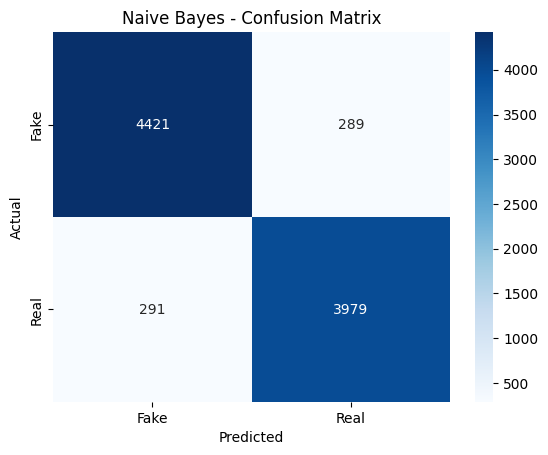


Logistic Regression
Accuracy : 0.9828507795100223
Precision: 0.9799440298507462
Recall   : 0.9840749414519906
F1 Score : 0.9820051413881749

Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98      4710
           1       0.98      0.98      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



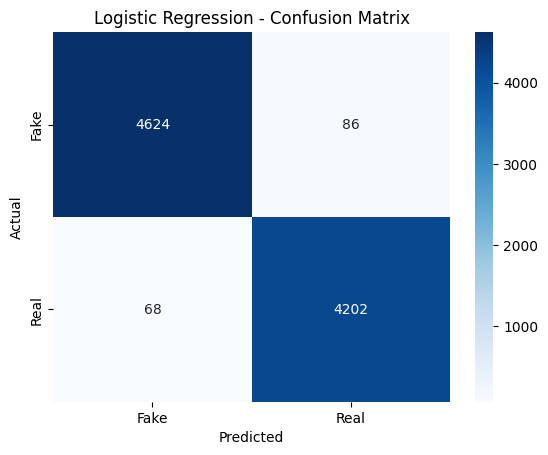

In [52]:
def evaluate_model(name, model, X_test, y_test):
    y_pred = model.predict(X_test)
    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Naive Bayes", nb_model, X_test_tfidf, y_test)
evaluate_model("Logistic Regression", lr_model, X_test_tfidf, y_test)

281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step

LSTM (Deep Learning)
Accuracy : 0.9811804008908686
Precision: 0.9778606385457935
Recall   : 0.9826697892271663
F1 Score : 0.9802593155005256

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.98      0.98      4710
           1       0.98      0.98      0.98      4270

    accuracy                           0.98      8980
   macro avg       0.98      0.98      0.98      8980
weighted avg       0.98      0.98      0.98      8980



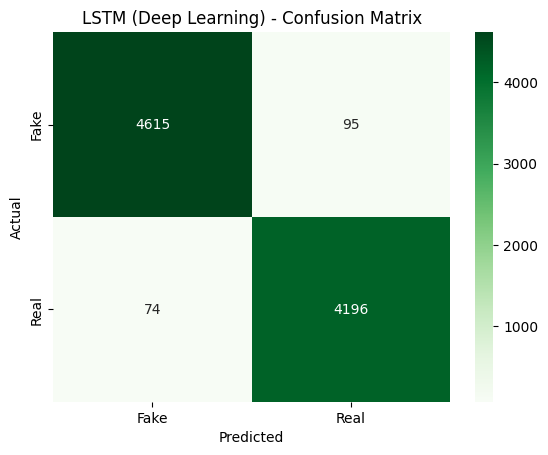

In [53]:
def evaluate_model(name, model, X_test, y_test, is_dl=False):
    if is_dl:
        y_pred = (model.predict(X_test) > 0.5).astype("int32")
    else:
        y_pred = model.predict(X_test)

    print(f"\n{name}")
    print("Accuracy :", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred))
    print("Recall   :", recall_score(y_test, y_pred))
    print("F1 Score :", f1_score(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("LSTM (Deep Learning)", model_lstm, X_test_pad, y_test, is_dl=True)

## 6. Summary of Results
## Final Results

| Model                        | Accuracy | Precision | Recall | F1 Score |
|------------------------------|----------|-----------|--------|----------|
| **LSTM (Deep Learning)**     | 98.57%   | 97.81%    | 99.23% | 98.51%   |
| **Logistic Regression**      | 98.29%   | 97.99%    | 98.40% | 98.20%   |
| **Naive Bayes**              | 93.54%   | 93.23%    | 93.18% | 93.21%   |


###  Breakdown & Observations

#### LSTM (Deep Learning)
- **Best performing model overall** in both recall and F1 score.
- Especially strong at minimizing false negatives — great for **not missing** fake news.
- Slightly more complex to train and deploy, but yields high returns.

#### Logistic Regression
- Very competitive and almost on par with LSTM.
- Simple, interpretable, and fast to train — an excellent baseline for NLP tasks.
- Balanced performance makes it highly reliable for production use.

#### Naive Bayes
- Performs reasonably well, but clearly lower than the other two.
- Extremely fast and lightweight — suitable for quick prototyping.
- Better as a benchmark model rather than final deployment.



## 7. WordCloud Visualization

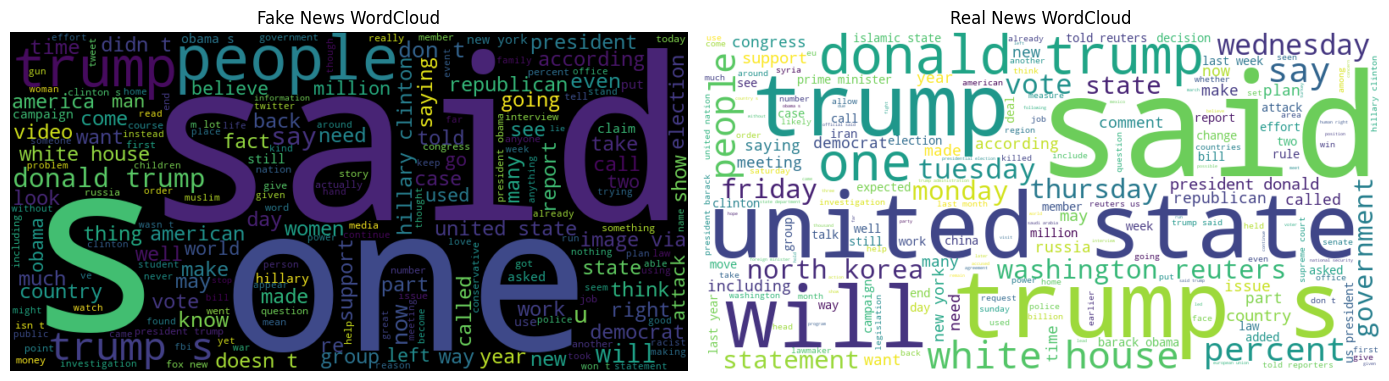

In [54]:
fake_text = " ".join(df[df.label == 0]['content'])
real_text = " ".join(df[df.label == 1]['content'])

fake_wc = WordCloud(width=800, height=400, background_color='black').generate(fake_text)
real_wc = WordCloud(width=800, height=400, background_color='white').generate(real_text)

plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
plt.imshow(fake_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Fake News WordCloud")

plt.subplot(1, 2, 2)
plt.imshow(real_wc, interpolation='bilinear')
plt.axis('off')
plt.title("Real News WordCloud")
plt.tight_layout()
plt.show()